<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
INPUT_DIR='drive/MyDrive/dataset'
!ls {INPUT_DIR}

ai_sc42x		  mountainForest       rating.csv.zip
animelist.csv		  mountainForest.zip   section4_p
anime_recommendation.zip  movie.csv.zip        test.zip
im_frog			  movie_rating	       wine_recommedation
__MACOSX		  movies_metadata.csv  wine_recommedation.zip


In [2]:
#!unzip /content/drive/MyDrive/dataset/movie.csv.zip -d /content/drive/MyDrive/dataset/movie_rating
#!unzip /content/drive/MyDrive/dataset/rating.csv.zip -d /content/drive/MyDrive/dataset/movie_rating

In [3]:
import numpy as np
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#read data
movie=pd.read_csv("/content/drive/MyDrive/dataset/movie_rating/movie.csv")
rating=pd.read_csv("/content/drive/MyDrive/dataset/movie_rating/rating.csv")

In [5]:
movie.shape, rating.shape

((27278, 3), (20000263, 4))

In [6]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [8]:
rating=rating.drop(['timestamp'],axis=1)

In [9]:
# user 별로 몇개의 애니메이션을 rating 했는지 확인
n_rating=rating['userId'].value_counts()
n_rating.describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: userId, dtype: float64

In [10]:
# 200개 이상의 rate를 준 유저만 사용
rating = rating[rating['userId'].isin(n_rating[n_rating >= 200].index)].copy()
len(rating)

12471876

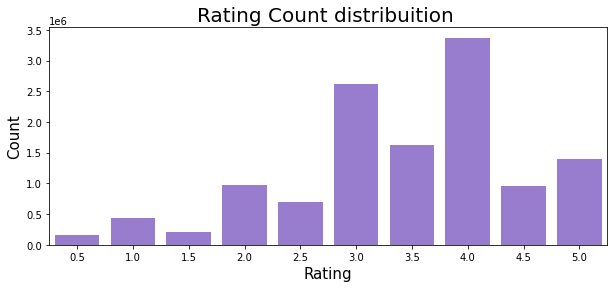

In [11]:
plt.figure(figsize=(10, 4))
graph = sns.countplot(x='rating', data=rating, color='mediumpurple')
graph.set_title("Rating Count distribuition ", fontsize=20)
graph.set_xlabel("Rating", fontsize=15) 
graph.set_ylabel("Count", fontsize=15)
plt.show()

In [12]:
# rating 0~1로 정규화(?) 해주기
min_rating = min(rating['rating'])
max_rating = max(rating['rating'])
print(min_rating, max_rating)

rating['rating'] = rating["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating['rating'])
print('Avg', AvgRating)

0.5 5.0
Avg 0.6537791731343117


In [13]:
# 중복행이 있는지 확인하고 제거
duplicates = rating.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating = rating[~duplicates]

print('> {} duplicates'.format(rating.duplicated().sum()))

> 0 duplicates


In [29]:
#연도 지우기
movie['title']=movie['title'].str[:-7]

### user와 movie 0부터 매핑해주기

In [14]:
# Encoding categorical data
user_ids = rating["userId"].unique().tolist() 
user2user_encoded = {x: i for i, x in enumerate(user_ids)} # {2:0, 6:1, 12:2, 16:3, ...}
user_encoded2user = {i: x for i, x in enumerate(user_ids)} # {0:2, 1:6, 2:12, 3:16, ...}

rating["user"] = rating["userId"].map(user2user_encoded) #user를 0부터 새로운 인덱스로 mapping
n_users = len(user2user_encoded)

In [15]:
movie_ids = rating["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)} # {24833:0, 235:1, 36721:2, 40956:3, ...}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
rating["movie"] = rating["movieId"].map(movie2movie_encoded)
n_movies = len(movie2movie_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_movies))
print("Min rating: {}, Max rating: {}".format(min(rating['rating']), max(rating['rating'])))

Num of users: 26826, Num of animes: 26539
Min rating: 0.0, Max rating: 1.0


In [16]:
rating.head()

,userId,movieId,rating,user,movie
541,7,3,0.555556,0,0
542,7,7,0.555556,0,1
543,7,11,0.777778,0,2
544,7,15,0.333333,0,3
545,7,16,0.555556,0,4


### 200개 이상의 영화를 rating 한 유저들만 추출한 후, 각 유저 별, 애니메이션을 0부터 매핑완료(바꾼 것이 아님 !!)
- user 수 : 26826 (0~26825)
- movie 수 : 26539 (0~26538)

### 모델링

In [17]:
# Shuffle
rating = rating.sample(frac=1, random_state=73)

X = rating[['user', 'movie']].values
y = rating["rating"]

In [18]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating.shape[0] - test_set_size #71418113-10000

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 12461876
> Test set ratings: 10000


In [19]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [20]:
X_train_array
#유저 index
#애니메이션 index

[array([25961,  9313,  6932, ..., 11645,  6334, 23074]),
 array([2113,  480, 4900, ...,   10, 6064, 2587])]

In [21]:
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam

- embedding

  - input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
  - output_dim: Integer. Dimension of the dense embedding.
  - Input shape : 2D tensor with shape: (batch_size, input_length).
  - Output shape : 3D tensor with shape: (batch_size, input_length, output_dim).

- input shape

  여기서 shape = (1,) 엄밀히 말하면 vector가 한개라는 뜻이됩니다. 데이터 shape이 (5,1)일 경우 5행1열을 가진 데이터라는 뜻이 되는데요. 여기서 행은 무시하고 열!만 shape으로 입력을 해주는 것 입니다. 데이터는 계속 추가 될 수 있으므로 열(feature)만 중요

In [22]:
# Embedding layers
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 64
    
    #user
    user = Input(name = 'user', shape = [1]) # [1]=1=(1,)
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users,
                       output_dim = embedding_size)(user)
    user_flat =Flatten(name='FlattenUsers')(user_embedding)
                       
    #animation
    movie = Input(name = 'movie', shape = [1])
    movie_embedding = Embedding(name = 'movie_embedding',
                       input_dim = n_movies, 
                       output_dim = embedding_size)(movie)
    movie_flat =Flatten(name='FlattenMovie')(movie_embedding)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 1)([user_flat, movie_flat])
    #x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

In [23]:
model = RecommenderNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        1716864     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 64)        1698496     movie[0][0]                      
______________________________________________________________________________________________

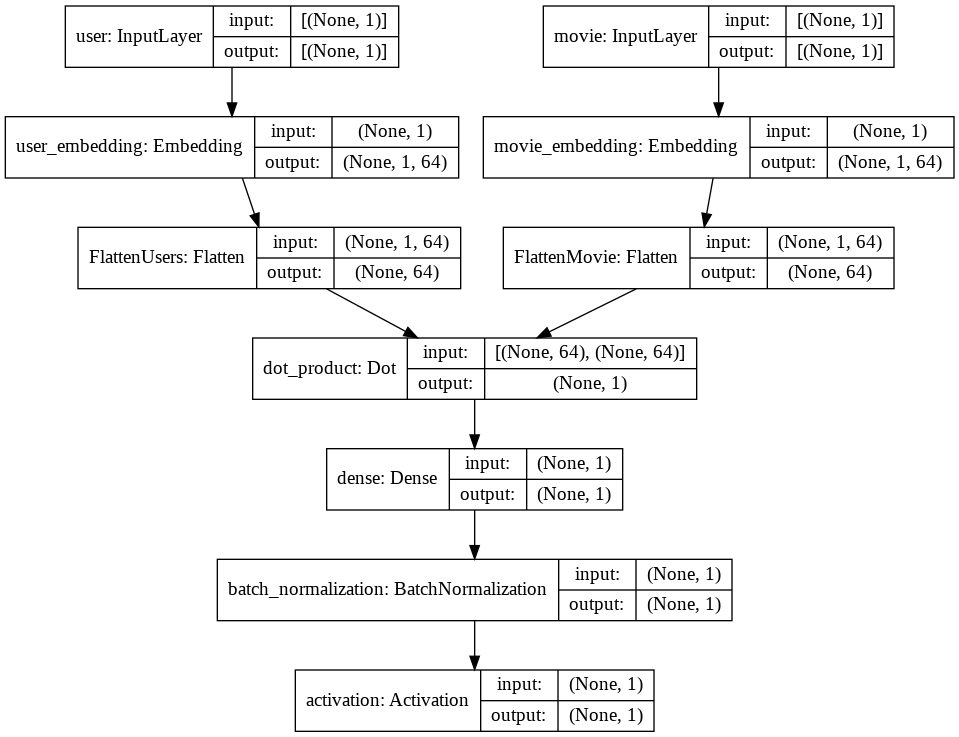

In [24]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='./dot.png',show_shapes=True, show_layer_names=True)

In [25]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = EarlyStopping(patience = 3, monitor='val_loss',mode='min', restore_best_weights=True)

checkpoint_filepath = './weights.h5'
# Validation Set을 기준으로 가장 최적의 모델을 찾기 위한 코드입니다.
save_best = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

my_callbacks = [
    save_best,
    early_stop   
]

In [26]:
# Model training
#con
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=10000,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
1247/1247 [==============================] - 48s 25ms/step - loss: 0.6879 - mae: 0.2146 - mse: 0.0728 - val_loss: 0.5973 - val_mae: 0.1377 - val_mse: 0.0318
Epoch 2/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5888 - mae: 0.1305 - mse: 0.0287 - val_loss: 0.5913 - val_mae: 0.1315 - val_mse: 0.0294
Epoch 3/20
1247/1247 [==============================] - 31s 25ms/step - loss: 0.5805 - mae: 0.1224 - mse: 0.0253 - val_loss: 0.5903 - val_mae: 0.1311 - val_mse: 0.0290
Epoch 4/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5763 - mae: 0.1182 - mse: 0.0236 - val_loss: 0.5896 - val_mae: 0.1307 - val_mse: 0.0287
Epoch 5/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5736 - mae: 0.1155 - mse: 0.0226 - val_loss: 0.5892 - val_mae: 0.1304 - val_mse: 0.0286
Epoch 6/20
1247/1247 [==============================] - 30s 24ms/step - loss: 0.5720 - mae: 0.1137 - mse: 0.0219 - val_loss: 0.5890 - val_mae: 0.1297 - val_mse:

In [27]:
#get_weights() : 훈련 중 업데이트 되고 있는 가중치 값 확인 가능한 함수
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

movie_weights = extract_weights('movie_embedding', model)
user_weights = extract_weights('user_embedding', model)

영화 이름 출력하는 함수 만들기

In [28]:
movie=pd.read_csv("/content/drive/MyDrive/dataset/movie_rating/movie.csv")
movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [32]:
# Fixing Names
def getMovieName(id_or_name):
    try: #eng_version 또는 Name의 값으로 return
        name = movie[movie.movieId == id_or_name].movieId.values[0]
        if name is np.nan:
            name = movie[movie.title == id_or_name].title.values[0]
    except:
        print('error')
    
    return name

In [33]:
def getMovieFrame(id_or_name):
    if isinstance(id_or_name, int):
        return movie[movie.movieId == id_or_name]
    if isinstance(id_or_name, str):
        return movie[movie.title == id_or_name]

In [36]:
def find_similar_movies(name, n=10, return_dist=False, neg=False):
    try:
        index = getMovieFrame(name).movieId.values[0]
        encoded_index = movie2movie_encoded.get(index)
        weights = movie_weights #anime_weights=extract_weights('anime_embedding', model)
      
        dists = np.dot(weights, weights[encoded_index]) #모든 애니메이션의 임베팅 벡터와 구하고자 하는 애니메이션의 임베팅 벡터와 내적연산하여 유사성을 계산
        sorted_dists = np.argsort(dists) #연관도 순서별로 인덱스를 저장
        #[0.3 0.7 0.02] => [2 0 1]
       

        #자기 자신과는 1이 유사도로 나오므로 +1 해줘야 원하는 개수를 구할 수 있음
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = movie
        
        #print(closest)
        SimilarityArr = []

        #유사하게 나온 영화들의 정보 출력
        for close in closest:
            decoded_id = movie_encoded2movie.get(close)
            #sypnopsis = getSypnopsis(decoded_id)
            movie_frame = getMovieFrame(decoded_id)
            
            movie_name = movie_frame.title.values[0]
            genre = movie_frame.genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": movie_name,
                                  "similarity": similarity,"genre": genre
                                  })
        #print(len(SimilarityArr))
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[1:n] #자기 자신을 제외하고 return 
        #return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [99]:
movie[movie['title'].str.contains('stella')]

,movieId,title,genres
9494,27800,Interstella 5555: The 5tory of the 5ecret 5tar...,Adventure|Animation|Fantasy|Musical|Sci-Fi
15440,78684,"Acla, The Descent into Floristella (La discesa...",Drama
17477,88055,"Missing Star, The (La stella che non c'è)",Drama
18614,92670,"Jodorowsky Constellation, The (La constellatio...",Documentary
22919,109487,Interstellar,Sci-Fi|IMAX


In [100]:
find_similar_movies('Interstellar'	, n=5, neg=False)

animes closest to Interstellar


,anime_id,name,similarity,genre
4,79132,Inception,0.738510,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
3,104841,Gravity,0.667467,Action|Sci-Fi|IMAX
2,91529,"Dark Knight Rises, The",0.616229,Action|Adventure|Crime|IMAX
1,106782,"Wolf of Wall Street, The",0.591577,Comedy|Crime|Drama
0,74458,Shutter Island,0.588179,Drama|Mystery|Thriller


In [80]:
find_similar_movies('Howl\'s Moving Castle (Hauru no ugoku shiro)'	, n=5, neg=False)

animes closest to Howl's Moving Castle (Hauru no ugoku shiro)


,anime_id,name,similarity,genre
4,5618,Spirited Away (Sen to Chihiro no kamikakushi),0.874810,Adventure|Animation|Fantasy
3,3000,Princess Mononoke (Mononoke-hime),0.835721,Action|Adventure|Animation|Drama|Fantasy
2,7099,Nausicaä of the Valley of the Wind (Kaze no ta...,0.786321,Adventure|Animation|Drama|Fantasy|Sci-Fi
1,5971,My Neighbor Totoro (Tonari no Totoro),0.771906,Animation|Children|Drama|Fantasy
0,6350,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,0.751010,Action|Adventure|Animation|Children|Fantasy|Sc...


### Task 2: Finding Similar Users (User Based Recommendation)

In [179]:
print('> picking up random user')
#4 ,16,20
random_user=rating.sample(1, random_state=20).userId.values[0]
#ratings_per_user = rating.groupby('userId').size()
#random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=34).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 63494


In [111]:
def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = movie
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list'.format(name))

In [180]:
similar_users = find_similar_users(int(random_user), 
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

> users similar to #63494


,similar_users,similarity
4,33395,0.652453
3,13174,0.609574
2,103028,0.580283
1,32027,0.578836
0,8948,0.575101


## 유저선호도

In [113]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=400, height=200, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(8,6)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['genres']:
            if isinstance(genres, str):
                for genre in genres.split('|'):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(userId, plot=False, verbose=0):
    movies_watched_by_user = rating[rating.userId==userId]

    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          userId, len(movies_watched_by_user),
          movies_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')

    user_rating_percentile = np.percentile(movies_watched_by_user.rating, 75) #상위 75%의 ranking 저장
    movies_watched_by_user = movies_watched_by_user[movies_watched_by_user.rating >= user_rating_percentile] # 그 이상의 rating 을 갖는 영화만 추출
    top_movies_user = ( #상위 영화 index 저장
        movies_watched_by_user.sort_values(by="rating", ascending=False).head(20)
        .movieId.values
    )
    
    movie_df_rows = movie[movie["movieId"].isin(top_movies_user)]
    movie_df_rows = movie_df_rows[["title", "genres"]]
    
    
    
    if plot:
        getFavGenre(movie_df_rows, plot)
        
    return movie_df_rows

> User #63494 has rated 594 movies (avg. rating = 0.5)
> preferred genres


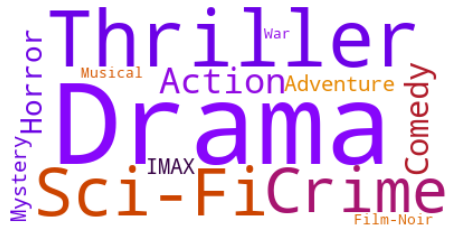

> movies highly rated by this user


,title,genres
1068,Platoon,Drama|War
1304,"Birds, The",Horror|Thriller
1684,Dark City,Adventure|Film-Noir|Sci-Fi|Thriller
2832,Ferris Bueller's Day Off,Comedy
2873,Fight Club,Action|Crime|Drama|Thriller
3933,"O Brother, Where Art Thou?",Adventure|Comedy|Crime
4132,Memento,Mystery|Thriller
5917,City of God (Cidade de Deus),Action|Adventure|Crime|Drama|Thriller
6392,28 Days Later,Action|Horror|Sci-Fi
8227,I Heart Huckabees,Comedy


In [181]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> movies highly rated by this user')

test=pd.DataFrame(user_pref)
test

### 유사도가 제일 높은 유저와 장르 선호도 비교(wordcloud)

> User #33395 has rated 411 movies (avg. rating = 0.5)
> preferred genres


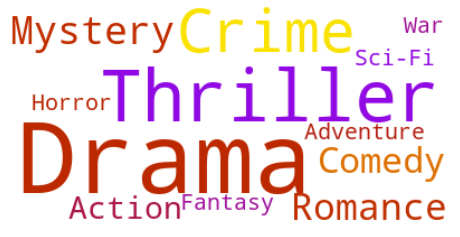

> animes highly rated by this user


,title,genres
109,Taxi Driver,Crime|Drama|Thriller
257,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi
523,Schindler's List,Drama|War
537,Blade Runner,Action|Sci-Fi|Thriller
587,"Silence of the Lambs, The",Crime|Horror|Thriller
843,"Godfather, The",Crime|Drama
886,Vertigo,Drama|Mystery|Romance|Thriller
895,Casablanca,Drama|Romance
906,Citizen Kane,Drama|Mystery
907,2001: A Space Odyssey,Adventure|Drama|Sci-Fi


In [182]:
first_similar_user=similar_users.iloc[:,0][4]
firstsim_user_pref = get_user_preferences(first_similar_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(firstsim_user_pref)

In [116]:
def get_recommended_movies(similar_users, n=10):
    recommended_movies = []
    movie_list = []
    
    #비슷한 유저들이 시청한 애니메이션을 movie_list 추가(이미 본 애니메이션은 제거)
    for user_id in similar_users.similar_users.values: #유저번호
        pref_list = get_user_preferences(int(user_id), verbose=0) #비슷한 유저a가 시청한 리스트
        pref_list = pref_list[~ pref_list.title.isin(user_pref.title.values)] #user가 시청한 목록은 제거(이미 봤으니 추천해줄 이유 x)
        movie_list.append(pref_list.title.values)
        
    movie_list = pd.DataFrame(movie_list)
    sorted_list = pd.DataFrame(pd.Series(movie_list.values.ravel()).value_counts()).head(n) #제일 많이 추천된(카운트된) 순으로 정렬
    
    for i, movie_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list[sorted_list.index == movie_name].values[0][0]
        if isinstance(movie_name, str):
            try:
                frame = getMovieFrame(movie_name)
                movie_id = frame.movieId.values[0]
                genre = frame.genres.values[0]
                #sypnopsis = getSypnopsis(int(anime_id))
                recommended_movies.append({"movie_id": movie_id ,
                                            "n": n_user_pref,
                                            "movie_name": movie_name, 
                                            "genres": genre, 
                                            #"sypnopsis": sypnopsis
                                           })
            except:
                pass
    
    return pd.DataFrame(recommended_movies)

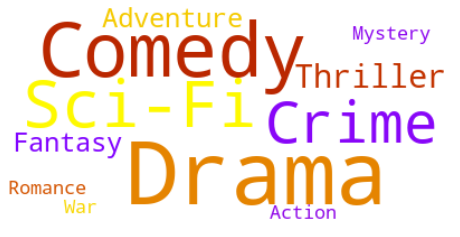


> Top recommendations for user: 63494


,movie_id,n,movie_name,genres
0,1206,3,"Clockwork Orange, A",Crime|Drama|Sci-Fi|Thriller
1,858,3,"Godfather, The",Crime|Drama
2,924,2,2001: A Space Odyssey,Adventure|Drama|Sci-Fi
3,4011,2,Snatch,Comedy|Crime|Thriller
4,4878,2,Donnie Darko,Drama|Mystery|Sci-Fi|Thriller
5,1247,2,"Graduate, The",Comedy|Drama|Romance
6,2716,2,Ghostbusters (a.k.a. Ghost Busters),Action|Comedy|Sci-Fi
7,527,2,Schindler's List,Drama|War
8,1136,2,Monty Python and the Holy Grail,Adventure|Comedy|Fantasy
9,2997,2,Being John Malkovich,Comedy|Drama|Fantasy


In [184]:
recommended_movies = get_recommended_movies(similar_users, n=10)
getFavGenre(recommended_movies, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_movies

In [134]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

movies_watched_by_user = rating[rating.userId==random_user] #유저a가 시청한 애니메이션 목록
movie_not_watched_df = movie[ # 유저a가 시청하지 않은 애니메이션 목록
    ~movie["movieId"].isin(movies_watched_by_user.movieId.values)
]

movie_not_watched = list(
    set(movie_not_watched_df['movieId']).intersection(set(movie2movie_encoded.keys())) #교집합 만들기
)

movie_not_watched = [[movie2movie_encoded.get(x)] for x in movie_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

user_movie_array = [user_movie_array[:, 0], user_movie_array[:, 1]] #input
ratings = model.predict(user_movie_array).flatten() #output

top_ratings_indices = (-ratings).argsort()[:10]

recommended_movie_ids = [
    movie_encoded2movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, movie_id in enumerate(movie_not_watched):
    predd_rating = ratings[index]
    id_ = movie_encoded2movie.get(movie_id[0])
    
    if id_ in recommended_movie_ids:
        top_rated_ids.append(id_)
        try:
            condition = (movie.movieId == id_)
            name = movie[condition]['title'].values[0]
            genre = movie[condition].genres.values[0]
            #score = movie[condition].Score.values[0]
            #sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": predd_rating,
                        "genre": genre, 
                        #'sypnopsis': sypnopsis
                        })

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)

#test
#test=pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)

pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)


Showing recommendations for user: 3397
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre
6,Precision: The Measure of All Things,0.951396,Documentary
4,Latin Music USA,0.948712,Documentary|Musical
7,Shock and Awe: The Story of Electricity,0.946489,Documentary
8,"Story of Science, The",0.945037,Documentary
0,"Not on Your Life (Verdugo, El) (Executioner, The)",0.941328,Comedy|Drama
5,"Story of Maths, The",0.940280,Documentary
2,"Moth, The (Cma)",0.935600,Drama
1,Above and Beyond,0.930194,Action|Drama
9,Craig Ferguson: A Wee Bit o' Revolution,0.929603,Comedy
3,"Summer Wishes, Winter Dreams",0.929223,Drama
